In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
import codecs
from sklearn import ensemble, preprocessing, metrics, linear_model, svm
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit
import networkx as nx

In [2]:
def GetData(): # get the data from excel
    with open("billboard_2000_2018_spotify_lyrics.csv", newline='', encoding="utf8", errors='ignore') as csvfile:
        X_colnames = next(csv.reader(csvfile))

    X_date = []
    X_title = []
    X_peak_pos = []
    X_last_pos = []
    X_weeks = []
    X_rank = []
    X_change = []
    X_genre = []
    X_energy = []
    X_liveness = []
    X_tempo = []
    X_speechiness = []
    X_acousticness = []
    X_instrumentalness = []
    X_danceability = []
    X_key = []
    X_duration_ms = []
    X_loudness = []
    X_valence = []
    X_mode = []
    with open("billboard_2000_2018_spotify_lyrics.csv", newline='', encoding="utf8", errors='ignore') as csvfile:
        #X_colnames = next(csv.reader(csvfile))
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row[X_colnames[X_colnames.index('valence')]] != 'unknown':
                X_date.append(row[X_colnames[X_colnames.index('date')]])
                X_title.append(row[X_colnames[X_colnames.index('title')]])
                X_peak_pos.append(row[X_colnames[X_colnames.index('peak_pos')]])
                X_last_pos.append(row[X_colnames[X_colnames.index('last_pos')]])
                X_weeks.append(row[X_colnames[X_colnames.index('weeks')]])
                X_rank.append(row[X_colnames[X_colnames.index('rank')]])
                X_change.append(row[X_colnames[X_colnames.index('change')]])
                X_genre.append(row[X_colnames[X_colnames.index('genre')]])
                X_energy.append(row[X_colnames[X_colnames.index('energy')]])
                X_liveness.append(row[X_colnames[X_colnames.index('liveness')]])
                X_tempo.append(row[X_colnames[X_colnames.index('tempo')]])
                X_speechiness.append(row[X_colnames[X_colnames.index('speechiness')]])
                X_acousticness.append(row[X_colnames[X_colnames.index('acousticness')]])
                X_instrumentalness.append(row[X_colnames[X_colnames.index('instrumentalness')]])
                X_danceability.append(row[X_colnames[X_colnames.index('danceability')]])
                X_key.append(row[X_colnames[X_colnames.index('key')]])
                X_duration_ms.append(row[X_colnames[X_colnames.index('duration_ms')]])
                X_loudness.append(row[X_colnames[X_colnames.index('loudness')]])
                X_valence.append(row[X_colnames[X_colnames.index('valence')]])
                X_mode.append(row[X_colnames[X_colnames.index('mode')]])
                
    return np.array(X_date), np.array(X_title), np.array(X_peak_pos), np.array(X_last_pos), np.array(X_weeks), np.array(X_rank), np.array(X_change), X_genre, np.array(X_energy), np.array(X_liveness), np.array(X_tempo), np.array(X_speechiness), np.array(X_acousticness), np.array(X_instrumentalness), np.array(X_danceability), np.array(X_key), np.array(X_duration_ms), np.array(X_loudness), np.array(X_valence), np.array(X_mode)


In [3]:
def DistMap(): # construct a distance map for [3, 10, 25, 50, 100] mapping
    distMap = dict()
    for i in range(0,101):
        if i==0:
            distMap[i] = -1
        elif i>=1 and i<=3:
            distMap[i] = 0
        elif i<=10 and i>=4:
            distMap[i] = 1
        elif i<=25 and i>=11:
            distMap[i] = 2
        elif i<=50 and i>=26:
            distMap[i] = 3
        else:
            distMap[i] = 4
    return distMap

In [4]:
def dataPreprocessing(dist, X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, 
                      X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode):
    # make all features into proper data type
    X_energy = X_energy.astype('float64')
    X_liveness = X_liveness.astype('float64')
    X_tempo = X_tempo.astype('float64')
    X_speechiness = X_speechiness.astype('float64')
    X_acousticness = X_acousticness.astype('float64')
    X_instrumentalness = X_instrumentalness.astype('float64')
    X_danceability = X_danceability.astype('float64')
    X_duration_ms = X_duration_ms.astype('float64')
    X_loudness = X_loudness.astype('float64')
    X_valence = X_valence.astype('float64')
    X_peak_pos = X_peak_pos.astype('int')
    X_last_pos = X_last_pos.astype('int')
    X_weeks = X_weeks.astype('int')
    X_rank = X_rank.astype('int')
    X_key = X_key.astype('int')
    X_mode = X_mode.astype('int')
    
    # try to combine X_key and X_mode into one feature 
    X_key_mode = np.zeros(len(X_key))
    for i in range(len(X_key)):
        if X_mode[i]==1:
            X_key_mode[i] = X_key[i]
        else:
            X_key_mode[i] = (-1) * X_key[i]
            
    # normalize data to zero mean with variance one
    #X_energy = preprocessing.scale(X_energy)
    #X_liveness = preprocessing.scale(X_liveness)
    X_tempo = preprocessing.scale(X_tempo)
    #X_speechiness = preprocessing.scale(X_speechiness)
    #X_acousticness = preprocessing.scale(X_acousticness)
    #X_instrumentalness = preprocessing.scale(X_instrumentalness)
    #X_danceability = preprocessing.scale(X_danceability)
    X_duration_ms = preprocessing.scale(X_duration_ms)
    X_loudness = preprocessing.scale(X_loudness)
    X_key_mode = preprocessing.scale(X_key_mode)
    #X_valence = preprocessing.scale(X_valence)
    
    # 1. turn ranking into corresponding distance
    # 2. process non-numeric symbols 
        # if dist = 50, binary classification
        # if dist = 0, division will be [3, 10, 25, 50, 100]
    distMap = DistMap()
    for i in range(len(X_rank)):
        if X_change[i] == 'Re-Entry':
            X_change[i] = X_peak_pos[i] - X_weeks[i]
        elif X_change[i] == 'New' or X_change[i] == 'Hot Shot Debut':
            X_change[i] = 0
            X_peak_pos[i] = 0
            X_last_pos[i] = 0
        else:
            X_change[i] = X_last_pos[i] - X_rank[i]
            
        if dist != 0:
            X_rank[i] = int((X_rank[i]-1)/dist)
            X_peak_pos[i] = int((X_peak_pos[i]-1)/dist)
            X_last_pos[i] = int((X_last_pos[i]-1)/dist)
        else: # dist = 0
            X_rank[i] = distMap[X_rank[i]]
            X_peak_pos[i] = distMap[X_peak_pos[i]]
            X_last_pos[i] = distMap[X_last_pos[i]]
    
    return X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode, X_key_mode

In [5]:
def genrePreprocessing(X_genre):
    # create corresponding genre dictionary
    genre = []
    genre_dict = dict()
    for i in range(len(X_genre)):
        X_genre[i] = X_genre[i].replace('[', '')
        X_genre[i] = X_genre[i].replace(']', '')
        X_genre[i] = X_genre[i].split(',')
        for j in range(len(X_genre[i])):
            if j == 0:
                if X_genre[i][j] != '' and X_genre[i][j] != 'unknown':
                    if X_genre[i][j] not in genre:
                        genre.append(X_genre[i][j])
                        #print('[i, j, X]: ', i, j, X_genre[i][j])
                        genre_dict[X_genre[i][j]] = 1
                    else:
                        genre_dict[X_genre[i][j]] += 1
            else:
                if X_genre[i][j] != '' and X_genre[i][j] != 'unknown':
                    if X_genre[i][j][1:] not in genre:
                        genre.append(X_genre[i][j][1:])
                        #print('[i, j, X]: ', i, j, X_genre[i][j][1:])
                        genre_dict[X_genre[i][j][1:]] = 1
                    else:
                        genre_dict[X_genre[i][j][1:]] += 1
                    
    return genre_dict, genre

In [6]:
def dfSongGenre(X_genre, genre):    
    # create indicator matrix for song and genre
    genre_indicator = np.zeros((len(X_genre), len(genre)))
    for i in range(len(X_genre)):
        for j in range(len(X_genre[i])):
            if j == 0:
                if X_genre[i][j] != '' and X_genre[i][j] != 'unknown':
                    genre_indicator[i][genre.index(X_genre[i][j])] = 1
            else:
                if X_genre[i][j] != '' and X_genre[i][j] != 'unknown':
                    genre_indicator[i][genre.index(X_genre[i][j][1:])] = 1

    # create indicator data frame between song and genre
    df_song_genre = pd.DataFrame(genre_indicator,columns=genre)
    
    return genre_indicator, df_song_genre

In [7]:
def adjGenre(X_genre, genre):
    # create adjacency matrix for genre
    genre_Adj = np.zeros((len(genre), len(genre)))
    for i in range(len(X_genre)):
        if len(X_genre[i]) == 1:
            if X_genre[i][0] != '' and X_genre[i][0] != 'unknown':
                genre_Adj[genre.index(X_genre[i][0])][genre.index(X_genre[i][0])] += 1
        else:
            for j in range(len(X_genre[i])):
                if j == 0:
                    genre_Adj[genre.index(X_genre[i][j])][genre.index(X_genre[i][j])] += 1
                else:
                    genre_Adj[genre.index(X_genre[i][j][1:])][genre.index(X_genre[i][j][1:])] += 1
                for k in range(j+1, len(X_genre[i])):
                    if j == 0:
                        genre_Adj[genre.index(X_genre[i][j])][genre.index(X_genre[i][k][1:])] += 1
                        genre_Adj[genre.index(X_genre[i][k][1:])][genre.index(X_genre[i][j])] += 1
                    else:
                        genre_Adj[genre.index(X_genre[i][j][1:])][genre.index(X_genre[i][k][1:])] += 1
                        genre_Adj[genre.index(X_genre[i][k][1:])][genre.index(X_genre[i][j][1:])] += 1

    # create data frame for genre
    df_genre = pd.DataFrame(genre_Adj,columns=genre)
    
    return genre_Adj, df_genre

In [8]:
def GenreCentrality(genre_Adj):
    # calculate genre centrality
    G_genre = nx.Graph()
    G_genre = nx.from_numpy_matrix(genre_Adj)
    
    cc_centrality = nx.closeness_centrality(G_genre)
    cc = list(cc_centrality.values())

    bc_centrality = nx.betweenness_centrality(G_genre, weight='weight')
    bc = list(bc_centrality.values())

    dc_centrality = nx.degree_centrality(G_genre)
    dc = list(dc_centrality.values())

    ec_centrality = nx.eigenvector_centrality(G_genre, weight='weight')
    ec = list(ec_centrality.values())

    return cc, bc, dc, ec

In [9]:
def GenrelinearSum(genre_indicator, cc, bc, dc, ec):    
    # compute summation of the centralities for each genre
    X_genre_cc = genre_indicator @ cc
    X_genre_bc = genre_indicator @ bc
    X_genre_dc = genre_indicator @ dc
    X_genre_ec = genre_indicator @ ec
    
    X_genre_cc = preprocessing.scale(X_genre_cc)
    X_genre_bc = preprocessing.scale(X_genre_bc)
    X_genre_dc = preprocessing.scale(X_genre_dc)
    X_genre_ec = preprocessing.scale(X_genre_ec)
    
    return X_genre_cc, X_genre_bc, X_genre_dc, X_genre_ec

In [10]:
def GenreNum_Prob(X_genre, genre_dict, genre):
    # calculate number of genres on songs
    X_genre_num = np.zeros(len(X_genre))
    for i in range(len(X_genre)):
        if '' in  X_genre[i] or 'unknown' in X_genre[i]:
            X_genre_num[i] = 0
        else:
            X_genre_num[i] = len(X_genre[i])

    # find genre distribution and genre probability of songs
    X_genre_distribution = np.zeros(len(genre))
    for i in range(len(genre)):
        X_genre_distribution[i] = genre_dict[genre[i]]/int(sum(X_genre_num))

    X_genre_prob = np.zeros(len(X_genre))
    for i in range(len(X_genre)):
        if X_genre[i][0] == '' or X_genre[i][0] == 'unknown':
            X_genre_prob[i] = 0
        else:
            for j in range(len(X_genre[i])):
                if j == 0:
                    X_genre_prob[i] += X_genre_distribution[genre.index(X_genre[i][j])]
                else:
                    X_genre_prob[i] += X_genre_distribution[genre.index(X_genre[i][j][1:])]
    
    X_genre_num = preprocessing.scale(X_genre_num)
    X_genre_prob = preprocessing.scale(X_genre_prob)
    
    return X_genre_num, X_genre_distribution, X_genre_prob

In [11]:
def buildTrainTestData(data_X, data_y):
    # build taining and testing data
    train_X = data_X[71:]
    train_y = data_y[71:]
    test_X = data_X[:70]
    test_y = data_y[:70]
    
    return train_X, train_y, test_X, test_y

In [181]:
# get the data as np.array
[X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode] = GetData()

# data preprocessing
dist = 1 # distance for ranking
# dist = 0 # if dist = 0, division will be [3, 10, 25, 50, 100]
[X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode, X_key_mode] = dataPreprocessing(dist, X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode)


In [182]:
# create genre dictionary
[genre_dict, genre] = genrePreprocessing(X_genre)

# create genre dataframe
[genre_indicator, df_song_genre] = dfSongGenre(X_genre, genre)

# create adjacency matrix for genre
[genre_Adj, df_genre] = adjGenre(X_genre, genre)

# genre centrality calculation
[cc, bc, dc, ec] = GenreCentrality(genre_Adj)
# np.argmax(dc), np.argmax(cc), np.argmax(bc), np.argmax(ec) = (3, 2, 2, 3)

# create feature as linear summation of genres
[X_genre_cc, X_genre_bc, X_genre_dc, X_genre_ec] = GenrelinearSum(genre_indicator, cc, bc, dc, ec)

# create feature as number of genres and probability distribution of genres
[X_genre_num, X_genre_distribution, X_genre_prob] = GenreNum_Prob(X_genre, genre_dict, genre)

In [14]:
# build data from features
data_X = np.array([X_genre_num, (X_genre_prob*X_genre_num), X_genre_bc, X_genre_cc, X_genre_dc, X_genre_ec,
                    X_weeks, X_peak_pos, X_last_pos, #X_change[71:],
                    X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, 
                    X_duration_ms, X_loudness, X_valence, X_key_mode]).T
data_y = X_rank

[train_X, train_y, test_X, test_y] = buildTrainTestData(data_X, data_y)

In [15]:
# build random forest model
forest = ensemble.RandomForestClassifier(n_estimators = 100)
forest_fit = forest.fit(train_X, train_y)

# cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
cv_test_score = cross_val_score(forest, data_X, data_y, cv=cv)
print('cv_test_score:', cv_test_score)

# predict
test_y_predicted = forest.predict(test_X)

feature_importance = forest.feature_importances_
print('feature_importance:', feature_importance)

# performance
accuracy = metrics.accuracy_score(test_y, test_y_predicted)
print("accuracy: ", accuracy)

cv_test_score: [0.07688829 0.08322026 0.0877431  0.07869742 0.08412483 0.076436
 0.08819539 0.08231569 0.08367255 0.08457711]
feature_importance: [0.02390326 0.04132116 0.04195811 0.03947066 0.03940373 0.04151473
 0.05052447 0.0513871  0.06672349 0.05573109 0.0596599  0.05881902
 0.0585024  0.05855219 0.03146299 0.05841702 0.05886203 0.05835076
 0.05780031 0.04763557]
accuracy:  0.02857142857142857


In [1009]:
# build SVM model
linearSVM = svm.LinearSVC(max_iter=1000)
linearSVM_fit = linearSVM.fit(train_X, train_y)

# cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
cv_test_score = cross_val_score(forest, data_X, data_y, cv=cv)
print('cv_test_score:', cv_test_score)

# predict
test_y_predicted_SVM = linearSVM.predict(test_X)

SVMcoef = linearSVM.coef_ 
print('SVM coef:', SVMcoef)

# performance
accuracy_SVM = metrics.accuracy_score(test_y, test_y_predicted_SVM)
print("accuracy_SVM: ", accuracy_SVM)

cv_test_score: [0.94934419 0.9434645  0.94753505 0.93848937 0.94120308 0.9375848
 0.94210764 0.94527363 0.94708277 0.94527363]
SVM coef: [[-1.40521688e-01  7.15059483e-02 -1.00046008e-01  4.50284897e-01
   1.56416643e-03 -1.14852596e-01 -6.58520667e-02  1.25124218e+00
   1.36304148e+00  1.30595962e-01  1.20530648e-01 -6.97371267e-03
  -8.34751699e-02  1.62559284e-02  7.55039785e-02 -3.06411797e-02
  -1.61076956e-02  1.02947629e-02 -1.13466704e-01  4.99064308e-04]]
accuracy_SVM:  0.7


In [16]:
distance_list = np.array([1, 25, 50, 0])
len_dist = len(distance_list)
trials = 20

accuracy_temp_fst = np.zeros((len_dist, trials))
dist_Frobenius_norm_fst = np.zeros((len_dist, trials))
dist_medium_fst = np.zeros((len_dist, trials))
histogram_count_fst = np.zeros((len_dist, 100))

accuracy_temp_svm = np.zeros((len_dist, trials))
dist_Frobenius_norm_svm = np.zeros((len_dist, trials))
dist_medium_svm = np.zeros((len_dist, trials))
histogram_count_svm = np.zeros((len_dist, 100))

for dis in range(len(distance_list)):
###############---change data here---#######################################################################################
    # get the data as np.array
    [X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode] = GetData()
    
    dist = distance_list[dis]
    [X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode, X_key_mode] = dataPreprocessing(dist, X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode)

    # build data from features
    data_X = np.array([X_genre_num, (X_genre_prob*X_genre_num), X_genre_bc, X_genre_cc, X_genre_dc, X_genre_ec,
                        X_weeks, X_peak_pos, X_last_pos, #X_change[71:],
                        X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, 
                        X_duration_ms, X_loudness, X_valence, X_key_mode]).T
    data_y = X_rank
    # build taining and testing data
    [train_X, train_y, test_X, test_y] = buildTrainTestData(data_X, data_y)

###############---change data here---#######################################################################################

    for i in range(trials):
        if i%9==0:
            print('trials: ', i)

        # build random forest model
        forest = ensemble.RandomForestClassifier(n_estimators = 100)
        forest_fit = forest.fit(train_X, train_y)
        # predict
        test_y_predicted_fst = forest.predict(test_X)
        # performance
        accuracy_temp_fst[dis][i] = metrics.accuracy_score(test_y, test_y_predicted_fst)

        difference = abs(test_y_predicted_fst - test_y.T)
        dist_Frobenius_norm_fst[dis][i] = np.linalg.norm(difference)
        dist_medium_fst[dis][i] = np.median(difference)
        for j in range(len(difference)):
            histogram_count_fst[dis][difference[j]] += 1

        # build SVM model
        linearSVM = svm.LinearSVC(max_iter=1000)
        linearSVM_fit = linearSVM.fit(train_X, train_y)
        # predict
        test_y_predicted_svm = linearSVM.predict(test_X)

        # performance
        accuracy_temp_svm[dis][i] = metrics.accuracy_score(test_y, test_y_predicted_svm)

        difference = abs(test_y_predicted_svm - test_y.T)
        dist_Frobenius_norm_svm[dis][i] = np.linalg.norm(difference)
        dist_medium_svm[dis][i] = np.median(difference)
        for j in range(len(difference)):
            histogram_count_svm[dis][difference[j]] += 1

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [42]:
max(train_y)

0

In [19]:
accuracy_temp_fst[0,:]

array([0.02857143, 0.04285714, 0.        , 0.        , 0.        ,
       0.04285714, 0.02857143, 0.01428571, 0.04285714, 0.        ,
       0.        , 0.01428571, 0.01428571, 0.04285714, 0.05714286,
       0.02857143, 0.01428571, 0.02857143, 0.04285714, 0.        ])

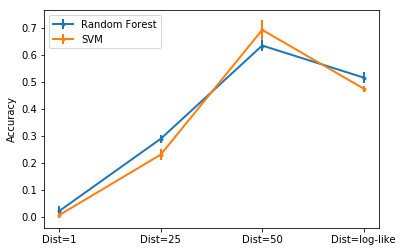

"\naccuracy_temp_fst = accuracy_temp_fst[:trials]\naccuracy_temp_svm = accuracy_temp_svm[:trials]\nfig = plt.figure()\nplt.plot(range(trials), accuracy_temp_fst, '-o')\nplt.plot(range(trials), accuracy_temp_svm, '-*')\nplt.legend(('Random Forest', 'SVM'))\nplt.ylabel('Accuracy (%)')\nplt.xlabel('# of Trials')\n\nplt.show()\nmean_accuracy_fst = np.mean(accuracy_temp_fst)\nstd_accuracy_fst = np.std(accuracy_temp_fst)\nprint('[mean_accuracy, std_accuracy]= ', [mean_accuracy_fst, std_accuracy_fst])\n\n"

In [41]:
mean_accuracy_fst = np.zeros(4)
std_accuracy_fst = np.zeros(4)
mean_accuracy_svm = np.zeros(4)
std_accuracy_svm = np.zeros(4)
for i in range(4):
    mean_accuracy_fst[i] = np.mean(accuracy_temp_fst[i,:])
    std_accuracy_fst[i] = np.std(accuracy_temp_fst[i,:])
    mean_accuracy_svm[i] = np.mean(accuracy_temp_svm[i,:])
    std_accuracy_svm[i] = np.std(accuracy_temp_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_accuracy_fst, std_accuracy_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_accuracy_svm, std_accuracy_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Accuracy')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])

plt.show()


fig.savefig('RF_SVM_20trials_dist_accuracy.png')

with open('RF_SVM_20trials_dist_accuracy_fst.txt', 'w') as f:
    for item in accuracy_temp_fst:
        f.write("%s\n" % item)
with open('RF_SVM_20trials_dist_accuracy_svm.txt', 'w') as f:
    for item in accuracy_temp_fst:
        f.write("%s\n" % item)
'''
accuracy_temp_fst = accuracy_temp_fst[:trials]
accuracy_temp_svm = accuracy_temp_svm[:trials]
fig = plt.figure()
plt.plot(range(trials), accuracy_temp_fst, '-o')
plt.plot(range(trials), accuracy_temp_svm, '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Accuracy (%)')
plt.xlabel('# of Trials')

plt.show()
mean_accuracy_fst = np.mean(accuracy_temp_fst)
std_accuracy_fst = np.std(accuracy_temp_fst)
print('[mean_accuracy, std_accuracy]= ', [mean_accuracy_fst, std_accuracy_fst])

'''

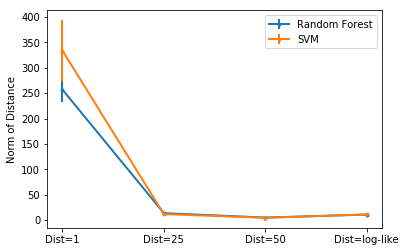

"fig = plt.figure()\nplt.plot(range(trials), dist_Frobenius_norm_fst, '-o')\nplt.plot(range(trials), dist_Frobenius_norm_svm, '-*')\nplt.legend(('Random Forest', 'SVM'))\nplt.ylabel('Norm of Distance')\nplt.xlabel('# of Trials')"

In [47]:
mean_dist_norm_fst = np.zeros(4)
std_dist_norm_fst = np.zeros(4)
mean_dist_norm_svm = np.zeros(4)
std_dist_norm_svm = np.zeros(4)
for i in range(4):
    mean_dist_norm_fst[i] = np.mean(dist_Frobenius_norm_fst[i,:])
    std_dist_norm_fst[i] = np.std(dist_Frobenius_norm_fst[i,:])
    mean_dist_norm_svm[i] = np.mean(dist_Frobenius_norm_svm[i,:])
    std_dist_norm_svm[i] = np.std(dist_Frobenius_norm_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_dist_norm_fst, std_dist_norm_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_dist_norm_svm, std_dist_norm_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Norm of Distance')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])

plt.show()


fig.savefig('RF_SVM_20trials_dist_norm.png')

with open('RF_SVM_20trials_dist_norm_fst.txt', 'w') as f:
    for item in dist_Frobenius_norm_fst:
        f.write("%s\n" % item)
with open('RF_SVM_20trials_dist_norm_svm.txt', 'w') as f:
    for item in dist_Frobenius_norm_svm:
        f.write("%s\n" % item)

'''fig = plt.figure()
plt.plot(range(trials), dist_Frobenius_norm_fst, '-o')
plt.plot(range(trials), dist_Frobenius_norm_svm, '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Norm of Distance')
plt.xlabel('# of Trials')'''

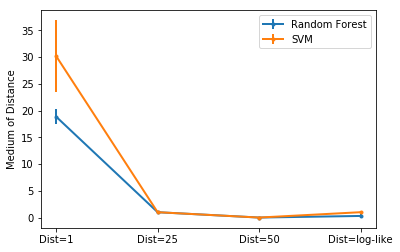

"fig = plt.figure()\nplt.plot(range(trials), dist_medium_fst, '-o')\nplt.plot(range(trials), dist_medium_svm, '-*')\nplt.legend(('Random Forest', 'SVM'))\nplt.ylabel('Medium of Distance')\nplt.xlabel('# of Trials')\n\nplt.show()"

In [48]:
mean_dist_medium_fst = np.zeros(4)
std_dist_medium_fst = np.zeros(4)
mean_dist_medium_svm = np.zeros(4)
std_dist_medium_svm = np.zeros(4)
for i in range(4):
    mean_dist_medium_fst[i] = np.mean(dist_medium_fst[i,:])
    std_dist_medium_fst[i] = np.std(dist_medium_fst[i,:])
    mean_dist_medium_svm[i] = np.mean(dist_medium_svm[i,:])
    std_dist_medium_svm[i] = np.std(dist_medium_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_dist_medium_fst, std_dist_medium_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_dist_medium_svm, std_dist_medium_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Medium of Distance')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])

plt.show()


fig.savefig('RF_SVM_20trials_dist_medium.png')

with open('RF_SVM_20trials_dist_medium_fst.txt', 'w') as f:
    for item in dist_medium_fst:
        f.write("%s\n" % item)
with open('RF_SVM_20trials_dist_medium_svm.txt', 'w') as f:
    for item in dist_medium_svm:
        f.write("%s\n" % item)


'''fig = plt.figure()
plt.plot(range(trials), dist_medium_fst, '-o')
plt.plot(range(trials), dist_medium_svm, '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Medium of Distance')
plt.xlabel('# of Trials')

plt.show()'''

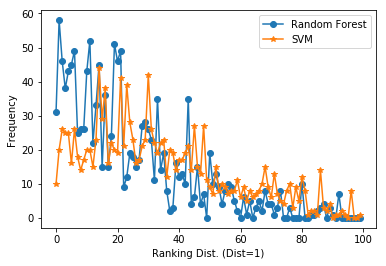

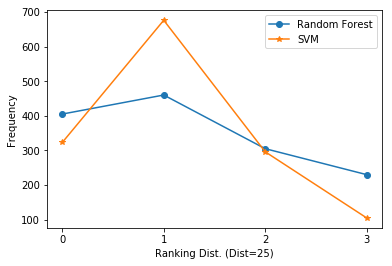

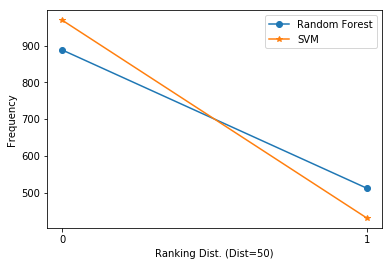

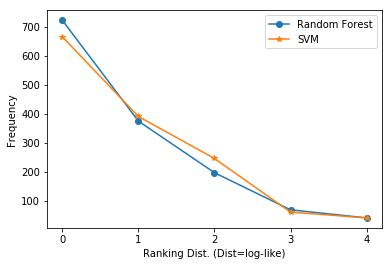

In [57]:
# Dist = 1
fig = plt.figure()
plt.plot(range(0,100), histogram_count_fst[0][:], '-o')
plt.plot(range(0,100), histogram_count_svm[0][:], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=1)')

plt.show()
fig.savefig('RF_SVM_20trials_dist1_hist.png')

# Dist = 25
fig = plt.figure()
plt.plot(range(0,4), histogram_count_fst[1][:4], '-o')
plt.plot(range(0,4), histogram_count_svm[1][:4], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=25)')
plt.xticks(range(4))

plt.show()
fig.savefig('RF_SVM_20trials_dist25_hist.png')

# Dist = 50
fig = plt.figure()
plt.plot(range(0,2), histogram_count_fst[2][:2], '-o')
plt.plot(range(0,2), histogram_count_svm[2][:2], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=50)')
plt.xticks(range(2))

plt.show()
fig.savefig('RF_SVM_20trials_dist50_hist.png')

# Dist = log-like
fig = plt.figure()
plt.plot(range(0,5), histogram_count_fst[3][:5], '-o')
plt.plot(range(0,5), histogram_count_svm[3][:5], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=log-like)')
plt.xticks(range(5))

plt.show()
fig.savefig('RF_SVM_20trials_distloglike_hist.png')


with open('RF_SVM_20trials_dist_hist_fst.txt', 'w') as f:
    for item in histogram_count_fst:
        f.write("%s\n" % item)
with open('RF_SVM_20trials_dist_hist_svm.txt', 'w') as f:
    for item in histogram_count_svm:
        f.write("%s\n" % item)



In [ ]:
# smaller network!!!!

In [164]:
# implement smaller network
distance_list = np.array([1, 25, 50, 0])
len_dist = len(distance_list)
trials = 51

batch_size = 400#2500
test_size = 100
data_size = batch_size + test_size
jump_range = int((len(X_title) - data_size)/(trials-1))


accuracy_temp_fst = np.zeros((len_dist, trials))
dist_Frobenius_norm_fst = np.zeros((len_dist, trials))
dist_medium_fst = np.zeros((len_dist, trials))
histogram_count_fst = np.zeros((len_dist, 100))

accuracy_temp_svm = np.zeros((len_dist, trials))
dist_Frobenius_norm_svm = np.zeros((len_dist, trials))
dist_medium_svm = np.zeros((len_dist, trials))
histogram_count_svm = np.zeros((len_dist, 100))

for dis in range(len(distance_list)):
###############---change data here---#######################################################################################
    # get the data as np.array
    [X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode] = GetData()
    
    dist = distance_list[dis]
    [X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode, X_key_mode] = dataPreprocessing(dist, X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode)

    # build data from features
    data_X = np.array([X_genre_num, (X_genre_prob*X_genre_num), X_genre_bc, X_genre_cc, X_genre_dc, X_genre_ec,
                        X_weeks, X_peak_pos, X_last_pos, #X_change[71:],
                        X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, 
                        X_duration_ms, X_loudness, X_valence, X_key_mode]).T
    data_y = X_rank

###############---change data here---#######################################################################################

    for i in range(trials):
        if i%9==0:
            print('trials: ', i)    
        
        if i!=51:
            # build taining and testing data (test[j:j+batch_size], train[j+batch_size:j+data_size])
            train_X = data_X[i*jump_range:i*jump_range+batch_size]
            train_y = data_y[i*jump_range:i*jump_range+batch_size]
            test_X = data_X[i*jump_range+batch_size:i*jump_range+data_size]
            test_y = data_y[i*jump_range+batch_size:i*jump_range+data_size]
        else:
            # build taining and testing data (test[7368-101-2500:7368-101], train[7368-101:7368])
            train_X = data_X[7368-data_size-1:7368-test_size-1]
            train_y = data_y[7368-data_size-1:7368-test_size-1]
            test_X = data_X[7368-test_size-1:7368]
            test_y = data_y[7368-test_size-1:7368]            

        # build random forest model
        forest = ensemble.RandomForestClassifier(n_estimators = 100)
        forest_fit = forest.fit(train_X, train_y)
        # predict
        test_y_predicted_fst = forest.predict(test_X)
        # performance
        accuracy_temp_fst[dis][i] = metrics.accuracy_score(test_y, test_y_predicted_fst)

        difference = abs(test_y_predicted_fst - test_y.T)
        dist_Frobenius_norm_fst[dis][i] = np.linalg.norm(difference)
        dist_medium_fst[dis][i] = np.median(difference)
        for j in range(len(difference)):
            histogram_count_fst[dis][difference[j]] += 1

        # build SVM model
        linearSVM = svm.LinearSVC(max_iter=1000)
        linearSVM_fit = linearSVM.fit(train_X, train_y)
        # predict
        test_y_predicted_svm = linearSVM.predict(test_X)

        # performance
        accuracy_temp_svm[dis][i] = metrics.accuracy_score(test_y, test_y_predicted_svm)

        difference = abs(test_y_predicted_svm - test_y.T)
        dist_Frobenius_norm_svm[dis][i] = np.linalg.norm(difference)
        dist_medium_svm[dis][i] = np.median(difference)
        for j in range(len(difference)):
            histogram_count_svm[dis][difference[j]] += 1

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  27


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  36


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  45


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  27


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  36


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  45


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  27


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  36


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  45


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  27


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  36


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  45


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

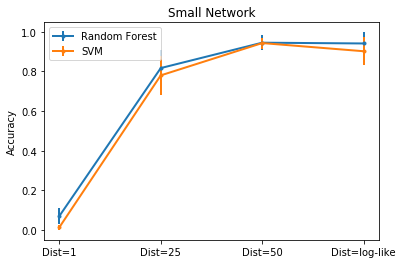

In [166]:
mean_accuracy_fst = np.zeros(4)
std_accuracy_fst = np.zeros(4)
mean_accuracy_svm = np.zeros(4)
std_accuracy_svm = np.zeros(4)
for i in range(4):
    mean_accuracy_fst[i] = np.mean(accuracy_temp_fst[i,:])
    std_accuracy_fst[i] = np.std(accuracy_temp_fst[i,:])
    mean_accuracy_svm[i] = np.mean(accuracy_temp_svm[i,:])
    std_accuracy_svm[i] = np.std(accuracy_temp_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_accuracy_fst, std_accuracy_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_accuracy_svm, std_accuracy_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Accuracy')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])
plt.title('Small Network')

plt.show()


fig.savefig('RF_SVM_smallNet_500_51trials_dist_accuracy.png')

with open('RF_SVM_smallNet_500_51trials_dist_accuracy_fst.txt', 'w') as f:
    for item in accuracy_temp_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_dist_accuracy_svm.txt', 'w') as f:
    for item in accuracy_temp_fst:
        f.write("%s\n" % item)
        

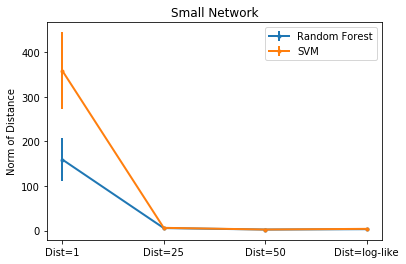

In [169]:
mean_dist_norm_fst = np.zeros(4)
std_dist_norm_fst = np.zeros(4)
mean_dist_norm_svm = np.zeros(4)
std_dist_norm_svm = np.zeros(4)
for i in range(4):
    mean_dist_norm_fst[i] = np.mean(dist_Frobenius_norm_fst[i,:])
    std_dist_norm_fst[i] = np.std(dist_Frobenius_norm_fst[i,:])
    mean_dist_norm_svm[i] = np.mean(dist_Frobenius_norm_svm[i,:])
    std_dist_norm_svm[i] = np.std(dist_Frobenius_norm_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_dist_norm_fst, std_dist_norm_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_dist_norm_svm, std_dist_norm_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Norm of Distance')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])
plt.title('Small Network')

plt.show()


fig.savefig('RF_SVM_smallNet_500_51trials_dist_norm.png')

with open('RF_SVM_smallNet_500_51trials_dist_norm_fst.txt', 'w') as f:
    for item in dist_Frobenius_norm_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_dist_norm_svm.txt', 'w') as f:
    for item in dist_Frobenius_norm_svm:
        f.write("%s\n" % item)
        

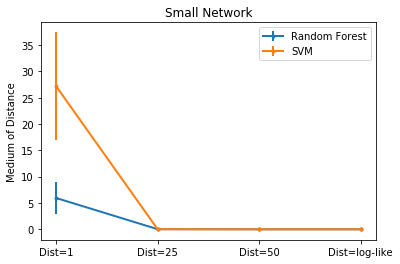

In [167]:
mean_dist_medium_fst = np.zeros(4)
std_dist_medium_fst = np.zeros(4)
mean_dist_medium_svm = np.zeros(4)
std_dist_medium_svm = np.zeros(4)
for i in range(4):
    mean_dist_medium_fst[i] = np.mean(dist_medium_fst[i,:])
    std_dist_medium_fst[i] = np.std(dist_medium_fst[i,:])
    mean_dist_medium_svm[i] = np.mean(dist_medium_svm[i,:])
    std_dist_medium_svm[i] = np.std(dist_medium_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_dist_medium_fst, std_dist_medium_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_dist_medium_svm, std_dist_medium_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Medium of Distance')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])
plt.title('Small Network')

plt.show()


fig.savefig('RF_SVM_smallNet_500_51trials_dist_medium.png')

with open('RF_SVM_smallNet_500_51trials_dist_medium_fst.txt', 'w') as f:
    for item in dist_medium_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_dist_medium_svm.txt', 'w') as f:
    for item in dist_medium_svm:
        f.write("%s\n" % item)



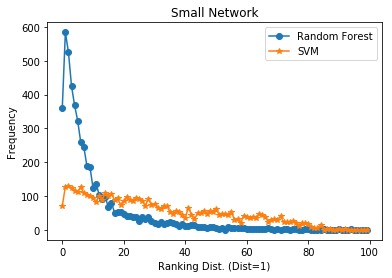

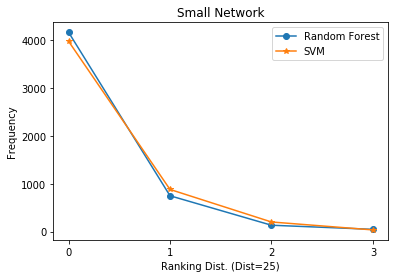

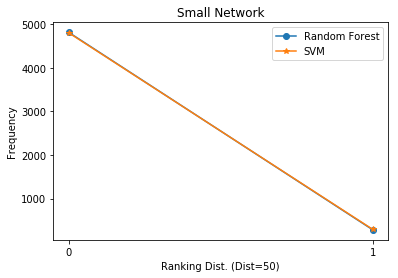

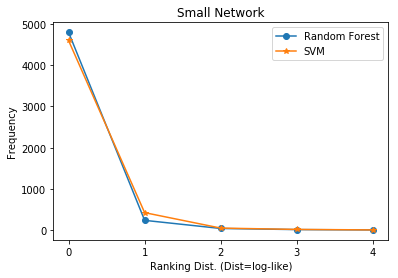

In [168]:
# Dist = 1
fig = plt.figure()
plt.plot(range(0,100), histogram_count_fst[0][:], '-o')
plt.plot(range(0,100), histogram_count_svm[0][:], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=1)')
plt.title('Small Network')

plt.show()
fig.savefig('RF_SVM_smallNet_500_51trials_dist1_hist.png')

# Dist = 25
fig = plt.figure()
plt.plot(range(0,4), histogram_count_fst[1][:4], '-o')
plt.plot(range(0,4), histogram_count_svm[1][:4], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=25)')
plt.xticks(range(4))
plt.title('Small Network')

plt.show()
fig.savefig('RF_SVM_smallNet_500_51trials_dist25_hist.png')

# Dist = 50
fig = plt.figure()
plt.plot(range(0,2), histogram_count_fst[2][:2], '-o')
plt.plot(range(0,2), histogram_count_svm[2][:2], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=50)')
plt.xticks(range(2))
plt.title('Small Network')

plt.show()
fig.savefig('RF_SVM_smallNet_500_51trials_dist50_hist.png')

# Dist = log-like
fig = plt.figure()
plt.plot(range(0,5), histogram_count_fst[3][:5], '-o')
plt.plot(range(0,5), histogram_count_svm[3][:5], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=log-like)')
plt.xticks(range(5))
plt.title('Small Network')

plt.show()
fig.savefig('RF_SVM_smallNet_500_51trials_distloglike_hist.png')


with open('RF_SVM_smallNet_500_51trials_dist_hist_fst.txt', 'w') as f:
    for item in histogram_count_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_dist_hist_svm.txt', 'w') as f:
    for item in histogram_count_svm:
        f.write("%s\n" % item)



In [238]:
np.shape(genre_indicator)

(7367, 390)

In [245]:
def adjGenre(data_size, genre_indicator, start):
    
    # create adjacency matrix for song
    song_Adj = np.zeros((data_size, data_size))
    
    for i in range(data_size):  
        song_Adj[i][i] = sum(genre_indicator[i + start])
        if song_Adj[i][i] == 0:
            song_Adj[i][i] = 1
        for j in range(i+1, data_size):
            count = sum(genre_indicator[i + start] * genre_indicator[j + start])
            song_Adj[i][j] = count
            song_Adj[j][i] = count

    # create data frame for song
    df_song = pd.DataFrame(song_Adj,columns=range(data_size))
    
    return song_Adj, df_song

In [277]:
def SongCentrality(song_Adj):    
    # calculate song centralities
    G_song = nx.Graph()
    G_song = nx.from_numpy_matrix(song_Adj)
    
    cc_centrality_song = nx.closeness_centrality(G_song)
    cc_song = list(cc_centrality.values())

    bc_centrality_song = nx.betweenness_centrality(G_song, weight='weight')
    bc_song = list(bc_centrality.values())

    dc_centrality_song = nx.degree_centrality(G_song)
    dc_song = list(dc_centrality.values())

    ec_centrality_song = nx.eigenvector_centrality(G_song, weight='weight')
    ec_song = list(ec_centrality.values())
        
    #X_song_cc = preprocessing.scale(cc_song)
    #X_song_bc = preprocessing.scale(bc_song)
    #X_song_dc = preprocessing.scale(dc_song)
    #X_song_ec = preprocessing.scale(ec_song)
    
    return cc_centrality, bc_centrality, dc_centrality, ec_centrality

In [247]:
# small network with song centrality!!

In [295]:
i*jump_range, i*jump_range+len(cc_centrality)

(411, 883)

In [307]:
len(X_date[7368-data_size-1:7368])

500

In [308]:
# implement smaller network
distance_list = np.array([1, 25, 50, 0])
len_dist = len(distance_list)
trials = 51

batch_size = 400#2500
test_size = 100
data_size = batch_size + test_size
jump_range = int((len(X_title) - data_size)/(trials-1))


accuracy_temp_fst = np.zeros((len_dist, trials))
dist_Frobenius_norm_fst = np.zeros((len_dist, trials))
dist_medium_fst = np.zeros((len_dist, trials))
histogram_count_fst = np.zeros((len_dist, 100))

accuracy_temp_svm = np.zeros((len_dist, trials))
dist_Frobenius_norm_svm = np.zeros((len_dist, trials))
dist_medium_svm = np.zeros((len_dist, trials))
histogram_count_svm = np.zeros((len_dist, 100))

for dis in range(len(distance_list)):
###############---change data here---#######################################################################################
    # get the data as np.array
    [X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode] = GetData()
    
    dist = distance_list[dis]
    [X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode, X_key_mode] = dataPreprocessing(dist, X_date, X_title, X_peak_pos, X_last_pos, X_weeks, X_rank, X_change, X_genre, X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, X_key, X_duration_ms, X_loudness, X_valence, X_mode)
    
###############---change data here---#######################################################################################

    for i in range(trials):
        if i%9==0:
            print('trials: ', i)    
            
        # create adjacency matrix for song
        if i!=51:
            [song_Adj, df_song] = adjGenre(data_size, genre_indicator, i*jump_range)        
            
            # calculate song centralities
            [cc_centrality, bc_centrality, dc_centrality, ec_centrality] = SongCentrality(song_Adj)
            X_song_cc = np.zeros(len(X_genre_num))
            X_song_bc = np.zeros(len(X_genre_num))
            X_song_dc = np.zeros(len(X_genre_num))
            X_song_ec = np.zeros(len(X_genre_num))

            for l in range(data_size):
                if l in cc_centrality.keys():
                    X_song_cc[i*jump_range+l] = cc_centrality[l]
                if l in bc_centrality.keys():
                    X_song_bc[i*jump_range+l] = bc_centrality[l]
                if l in dc_centrality.keys():
                    X_song_dc[i*jump_range+l] = dc_centrality[l]
                if l in ec_centrality.keys():
                    X_song_ec[i*jump_range+l] = ec_centrality[l]

            X_song_cc[i*jump_range:i*jump_range+data_size] = preprocessing.scale(X_song_cc[i*jump_range:i*jump_range+data_size])
            X_song_bc[i*jump_range:i*jump_range+data_size] = preprocessing.scale(X_song_bc[i*jump_range:i*jump_range+data_size])
            X_song_dc[i*jump_range:i*jump_range+data_size] = preprocessing.scale(X_song_dc[i*jump_range:i*jump_range+data_size])
            X_song_ec[i*jump_range:i*jump_range+data_size] = preprocessing.scale(X_song_ec[i*jump_range:i*jump_range+data_size])
        else:
            [song_Adj, df_song] = adjGenre(data_size, genre_indicator, 7368-data_size-1)     
            
            # calculate song centralities
            [cc_centrality, bc_centrality, dc_centrality, ec_centrality] = SongCentrality(song_Adj)
            X_song_cc = np.zeros(len(X_genre_num))
            X_song_bc = np.zeros(len(X_genre_num))
            X_song_dc = np.zeros(len(X_genre_num))
            X_song_ec = np.zeros(len(X_genre_num))

            for l in range(data_size):
                if l in cc_centrality.keys():
                    X_song_cc[7368-data_size-1+l] = cc_centrality[l]
                if l in bc_centrality.keys():
                    X_song_bc[7368-data_size-1+l] = bc_centrality[l]
                if l in dc_centrality.keys():
                    X_song_dc[7368-data_size-1+l] = dc_centrality[l]
                if l in ec_centrality.keys():
                    X_song_ec[7368-data_size-1+l] = ec_centrality[l]

            X_song_cc[7368-data_size-1:7368] = preprocessing.scale(X_song_cc[7368-data_size-1:7368])
            X_song_bc[7368-data_size-1:7368] = preprocessing.scale(X_song_bc[7368-data_size-1:7368])
            X_song_dc[7368-data_size-1:7368] = preprocessing.scale(X_song_dc[7368-data_size-1:7368])
            X_song_ec[7368-data_size-1:7368] = preprocessing.scale(X_song_ec[7368-data_size-1:7368])
        



        # build data from features
        data_X = np.array([X_genre_num, (X_genre_prob*X_genre_num), X_genre_bc, X_genre_cc, X_genre_dc, X_genre_ec,
                            X_song_cc, X_song_bc, X_song_dc, X_song_ec,
                            X_weeks, X_peak_pos, X_last_pos, #X_change[71:],
                            X_energy, X_liveness, X_tempo, X_speechiness, X_acousticness, X_instrumentalness, X_danceability, 
                            X_duration_ms, X_loudness, X_valence, X_key_mode]).T
        data_y = X_rank
        
        if i!=51:
            # build taining and testing data (test[j:j+batch_size], train[j+batch_size:j+data_size])
            train_X = data_X[i*jump_range:i*jump_range+batch_size]
            train_y = data_y[i*jump_range:i*jump_range+batch_size]
            test_X = data_X[i*jump_range+batch_size:i*jump_range+data_size]
            test_y = data_y[i*jump_range+batch_size:i*jump_range+data_size]
        else:
            # build taining and testing data (test[7368-101-2500:7368-101], train[7368-101:7368])
            train_X = data_X[7368-data_size-1:7368-test_size-1]
            train_y = data_y[7368-data_size-1:7368-test_size-1]
            test_X = data_X[7368-test_size-1:7368]
            test_y = data_y[7368-test_size-1:7368]            

        # build random forest model
        forest = ensemble.RandomForestClassifier(n_estimators = 100)
        forest_fit = forest.fit(train_X, train_y)
        # predict
        test_y_predicted_fst = forest.predict(test_X)
        # performance
        accuracy_temp_fst[dis][i] = metrics.accuracy_score(test_y, test_y_predicted_fst)

        difference = abs(test_y_predicted_fst - test_y.T)
        dist_Frobenius_norm_fst[dis][i] = np.linalg.norm(difference)
        dist_medium_fst[dis][i] = np.median(difference)
        for j in range(len(difference)):
            histogram_count_fst[dis][difference[j]] += 1

        # build SVM model
        linearSVM = svm.LinearSVC(max_iter=1000)
        linearSVM_fit = linearSVM.fit(train_X, train_y)
        # predict
        test_y_predicted_svm = linearSVM.predict(test_X)

        # performance
        accuracy_temp_svm[dis][i] = metrics.accuracy_score(test_y, test_y_predicted_svm)

        difference = abs(test_y_predicted_svm - test_y.T)
        dist_Frobenius_norm_svm[dis][i] = np.linalg.norm(difference)
        dist_medium_svm[dis][i] = np.median(difference)
        for j in range(len(difference)):
            histogram_count_svm[dis][difference[j]] += 1

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  27


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  36


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  45


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  27


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  36


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  45


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  27


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  36


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  45


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  0


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  9


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  18


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  27


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  36


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

trials:  45


C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\weich\Anaconda5\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

In [513]:
abs(test_y_predicted_svm - test_y.T)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

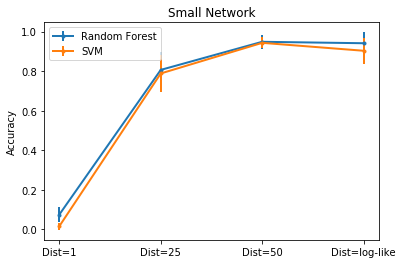

In [309]:
mean_accuracy_fst = np.zeros(4)
std_accuracy_fst = np.zeros(4)
mean_accuracy_svm = np.zeros(4)
std_accuracy_svm = np.zeros(4)
for i in range(4):
    mean_accuracy_fst[i] = np.mean(accuracy_temp_fst[i,:])
    std_accuracy_fst[i] = np.std(accuracy_temp_fst[i,:])
    mean_accuracy_svm[i] = np.mean(accuracy_temp_svm[i,:])
    std_accuracy_svm[i] = np.std(accuracy_temp_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_accuracy_fst, std_accuracy_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_accuracy_svm, std_accuracy_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Accuracy')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])
plt.title('Small Network')

plt.show()


fig.savefig('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_accuracy.png')

with open('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_accuracy_fst.txt', 'w') as f:
    for item in accuracy_temp_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_accuracy_svm.txt', 'w') as f:
    for item in accuracy_temp_fst:
        f.write("%s\n" % item)
        

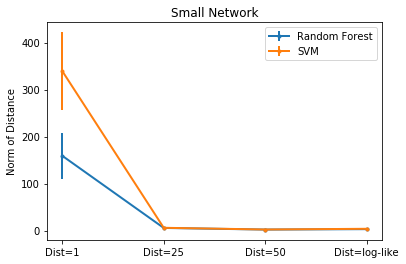

In [310]:
mean_dist_norm_fst = np.zeros(4)
std_dist_norm_fst = np.zeros(4)
mean_dist_norm_svm = np.zeros(4)
std_dist_norm_svm = np.zeros(4)
for i in range(4):
    mean_dist_norm_fst[i] = np.mean(dist_Frobenius_norm_fst[i,:])
    std_dist_norm_fst[i] = np.std(dist_Frobenius_norm_fst[i,:])
    mean_dist_norm_svm[i] = np.mean(dist_Frobenius_norm_svm[i,:])
    std_dist_norm_svm[i] = np.std(dist_Frobenius_norm_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_dist_norm_fst, std_dist_norm_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_dist_norm_svm, std_dist_norm_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Norm of Distance')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])
plt.title('Small Network')

plt.show()


fig.savefig('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_norm.png')

with open('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_norm_fst.txt', 'w') as f:
    for item in dist_Frobenius_norm_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_norm_svm.txt', 'w') as f:
    for item in dist_Frobenius_norm_svm:
        f.write("%s\n" % item)
        

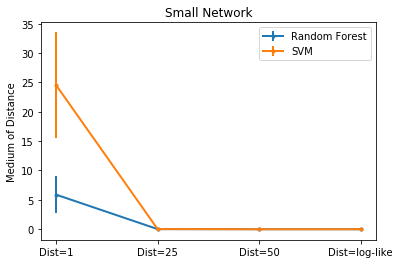

In [311]:
mean_dist_medium_fst = np.zeros(4)
std_dist_medium_fst = np.zeros(4)
mean_dist_medium_svm = np.zeros(4)
std_dist_medium_svm = np.zeros(4)
for i in range(4):
    mean_dist_medium_fst[i] = np.mean(dist_medium_fst[i,:])
    std_dist_medium_fst[i] = np.std(dist_medium_fst[i,:])
    mean_dist_medium_svm[i] = np.mean(dist_medium_svm[i,:])
    std_dist_medium_svm[i] = np.std(dist_medium_svm[i,:])

fig = plt.figure()
plt.errorbar(range(4), mean_dist_medium_fst, std_dist_medium_fst, marker=".", lw=2, capthick=2)
plt.errorbar(range(4), mean_dist_medium_svm, std_dist_medium_svm, marker=".", lw=2, capthick=2)

plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Medium of Distance')
plt.xticks([0., 1., 2., 3.], ["Dist=1", "Dist=25", "Dist=50", "Dist=log-like"])
plt.title('Small Network')

plt.show()


fig.savefig('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_medium.png')

with open('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_medium_fst.txt', 'w') as f:
    for item in dist_medium_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_medium_svm.txt', 'w') as f:
    for item in dist_medium_svm:
        f.write("%s\n" % item)



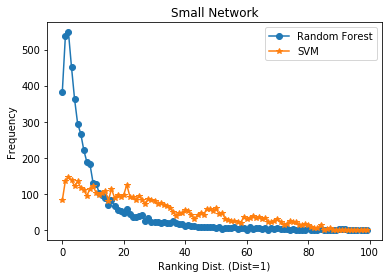

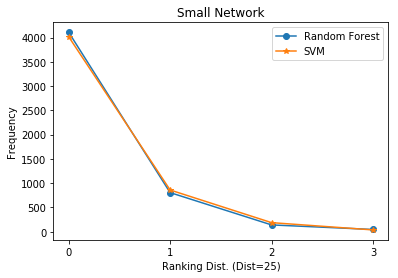

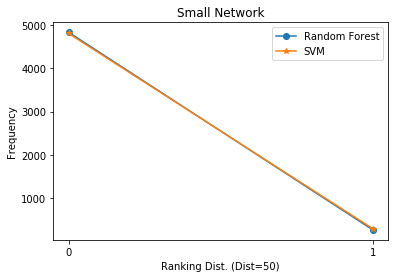

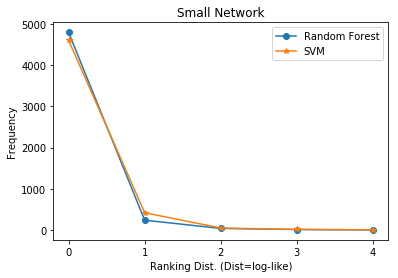

In [312]:
# Dist = 1
fig = plt.figure()
plt.plot(range(0,100), histogram_count_fst[0][:], '-o')
plt.plot(range(0,100), histogram_count_svm[0][:], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=1)')
plt.title('Small Network')

plt.show()
fig.savefig('RF_SVM_smallNet_500_51trials_w_songCentrl_dist1_hist.png')

# Dist = 25
fig = plt.figure()
plt.plot(range(0,4), histogram_count_fst[1][:4], '-o')
plt.plot(range(0,4), histogram_count_svm[1][:4], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=25)')
plt.xticks(range(4))
plt.title('Small Network')

plt.show()
fig.savefig('RF_SVM_smallNet_500_51trials_w_songCentrl_dist25_hist.png')

# Dist = 50
fig = plt.figure()
plt.plot(range(0,2), histogram_count_fst[2][:2], '-o')
plt.plot(range(0,2), histogram_count_svm[2][:2], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=50)')
plt.xticks(range(2))
plt.title('Small Network')

plt.show()
fig.savefig('RF_SVM_smallNet_500_51trials_w_songCentrl_dist50_hist.png')

# Dist = log-like
fig = plt.figure()
plt.plot(range(0,5), histogram_count_fst[3][:5], '-o')
plt.plot(range(0,5), histogram_count_svm[3][:5], '-*')
plt.legend(('Random Forest', 'SVM'))
plt.ylabel('Frequency')
plt.xlabel('Ranking Dist. (Dist=log-like)')
plt.xticks(range(5))
plt.title('Small Network')

plt.show()
fig.savefig('RF_SVM_smallNet_500_51trials_w_songCentrl_distloglike_hist.png')


with open('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_hist_fst.txt', 'w') as f:
    for item in histogram_count_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_w_songCentrl_dist_hist_svm.txt', 'w') as f:
    for item in histogram_count_svm:
        f.write("%s\n" % item)



In [314]:
forest.feature_importances_

array([0.00510356, 0.01070712, 0.01696856, 0.0062856 , 0.01344696,
       0.01465837, 0.00601506, 0.00920641, 0.00680579, 0.00974346,
       0.34756903, 0.12528649, 0.29837686, 0.0120086 , 0.01808972,
       0.01124988, 0.01314123, 0.01141162, 0.0068522 , 0.0139614 ,
       0.0134749 , 0.01275217, 0.00908574, 0.00779927])

In [315]:
linearSVM.coef_

array([[-0.31902047,  0.03441939,  0.24473077,  0.45042741, -0.5239891 ,
         0.17536458, -0.2433299 , -0.02653041,  0.41005982, -0.18026296,
        -0.14868206,  0.4618543 ,  0.23471348,  0.19253904,  0.33991079,
        -0.08488624,  0.00084286, -0.24156419,  0.1119263 ,  0.76080722,
        -0.04184351,  0.13911275, -0.38284232,  0.02502093]])

In [321]:
fi_fst = forest.feature_importances_
fi_svm = linearSVM.coef_
with open('RF_SVM_smallNet_500_51trials_w_songCentrl_featureImport_fst.txt', 'w') as f:
    for item in fi_fst:
        f.write("%s\n" % item)
with open('RF_SVM_smallNet_500_51trials_w_songCentrl_featureImport_svm.txt', 'w') as f:
    for item in fi_svm:
        f.write("%s\n" % item)

C:\Users\weich\Anaconda5\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


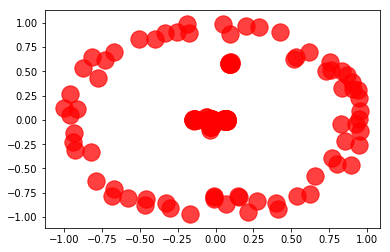

In [231]:
# construct graph with weight
G_song = nx.Graph()
G_song = nx.from_numpy_matrix(song_Adj)

pos = nx.spring_layout(G_song)
#ns = np.array(ec)*3000
nx.draw_networkx_nodes(G_song, pos, alpha=0.75)
#nx.draw_networkx_nodes(G_giant_component, pos, nodelist=centrality.keys(), node_size=ns, alpha=0.75)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_song, pos, alpha=0.7)
plt.show()

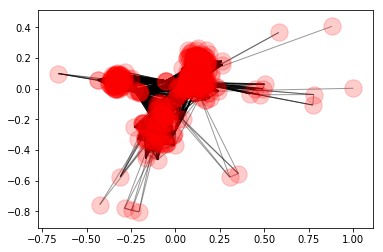

In [174]:
# construct graph with weight
rows, cols = np.where(song_Adj > 0)
edges = zip(rows.tolist(), cols.tolist())

# find largest component in graph
G_giant_component_song = max(nx.connected_component_subgraphs(G_song), key=len)
#G_genre.add_edges_from(edges)

pos = nx.spring_layout(G_giant_component_song)
nx.draw_networkx_nodes(G_giant_component_song, pos, alpha=0.2)
#ns = np.array(ec)*3000
#nx.draw_networkx_nodes(G_giant_component, pos, nodelist=centrality.keys(), node_size=ns, alpha=0.75)
#nx.draw_networkx_labels(G_genre, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_song, pos, width=1, alpha=0.4)
plt.show()

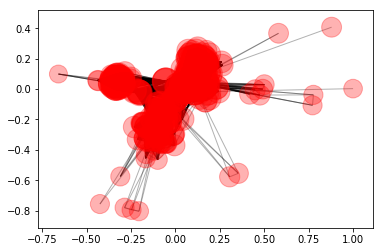

In [175]:
# compute closeness centrality with weight
cc_centrality = nx.closeness_centrality(G_giant_component_song)
cc = list(cc_centrality.values())

# scale size of nodes
ns = np.array(cc)*1000
nx.draw_networkx_nodes(G_giant_component_song, pos, nodelist=cc_centrality.keys(), node_size=ns, alpha=0.3)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_song, pos, alpha=0.3)
plt.show()

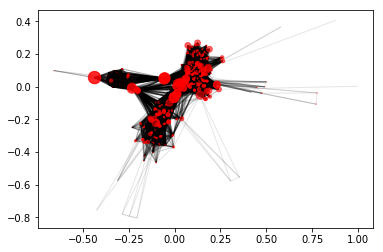

In [176]:
# compute betweenness centrality with weight
bc_centrality = nx.betweenness_centrality(G_giant_component_song, weight='weight')
bc = list(bc_centrality.values())

# scale size of nodes
ns = np.array(bc)*3000
nx.draw_networkx_nodes(G_giant_component_song, pos, nodelist=bc_centrality.keys(), node_size=ns, alpha=0.6)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_song, pos, alpha=0.1)
plt.show()

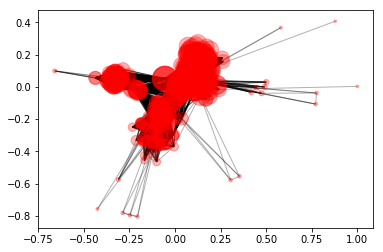

In [177]:
# compute degree centrality with weight
dc_centrality = nx.degree_centrality(G_giant_component_song)
dc = list(dc_centrality.values())

# scale size of nodes
ns = np.array(dc)*1000
nx.draw_networkx_nodes(G_giant_component_song, pos, nodelist=dc_centrality.keys(), node_size=ns, alpha=0.3)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_song, pos, alpha=0.3)
plt.show()

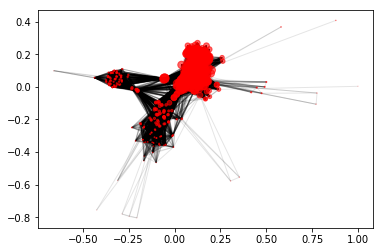

In [178]:
# compute eigenvector centrality with weight
ec_centrality = nx.eigenvector_centrality(G_giant_component_song, weight='weight')
ec = list(ec_centrality.values())

# scale size of nodes
ns = np.array(ec)*2000
nx.draw_networkx_nodes(G_giant_component_song, pos, nodelist=ec_centrality.keys(), node_size=ns, alpha=0.6)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_song, pos, alpha=0.1)
plt.show()

In [ ]:
#normalisation of data
#incorporate centrality measures to song data
#reduction of genre dimension
#above or below top 50 rather than individual ranks


In [643]:
# find division between weeks
index_weeks = []
prev_date = []
for i in range(len(X_date)):
    if prev_date != X_date[i]:
        prev_date = X_date[i]
        index_weeks.append(i)

In [786]:
[X_date[70], X_date[71]]

In [5]:
df_song_genre

,u'rap',u'pop rap',u'dance pop',u'pop',u'post-teen pop',u'contemporary country',u'country road',u'indie r&b',u'r&b',u'urban contemporary',...,u'deep norteno',u'duranguense',u'norteno',u'indie jazz',u'french pop',u'deep latin christian',u'grunge pop',u'hip house',u'italian pop',u'indie anthem-folk'
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_genre

,u'rap',u'pop rap',u'dance pop',u'pop',u'post-teen pop',u'contemporary country',u'country road',u'indie r&b',u'r&b',u'urban contemporary',...,u'deep norteno',u'duranguense',u'norteno',u'indie jazz',u'french pop',u'deep latin christian',u'grunge pop',u'hip house',u'italian pop',u'indie anthem-folk'
0,1828.0,1582.0,572.0,908.0,49.0,0.0,0.0,127.0,479.0,327.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1582.0,2201.0,1099.0,1195.0,325.0,0.0,0.0,195.0,797.0,630.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,572.0,1099.0,2685.0,2203.0,1392.0,37.0,0.0,259.0,1195.0,932.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,908.0,1195.0,2203.0,3114.0,1449.0,31.0,0.0,258.0,974.0,734.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49.0,325.0,1392.0,1449.0,1563.0,36.0,6.0,45.0,438.0,318.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,37.0,31.0,36.0,1252.0,1109.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,6.0,1109.0,1126.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,127.0,195.0,259.0,258.0,45.0,0.0,0.0,325.0,305.0,265.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,479.0,797.0,1195.0,974.0,438.0,0.0,0.0,305.0,1326.0,981.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,327.0,630.0,932.0,734.0,318.0,0.0,0.0,265.0,981.0,1044.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_song

,0,1,2,3,4,5,6,7,8,9,...,7357,7358,7359,7360,7361,7362,7363,7364,7365,7366
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,...,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0
3,1.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,2.0,2.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
5,1.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,2.0,2.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6,0.0,0.0,2.0,1.0,0.0,1.0,5.0,1.0,2.0,1.0,...,0.0,1.0,4.0,1.0,1.0,4.0,0.0,0.0,3.0,4.0
7,1.0,1.0,1.0,2.0,0.0,2.0,1.0,3.0,2.0,2.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
8,1.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,5.0,3.0,...,0.0,0.0,4.0,1.0,1.0,4.0,0.0,0.0,0.0,2.0
9,1.0,2.0,1.0,2.0,0.0,2.0,1.0,2.0,3.0,4.0,...,0.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0


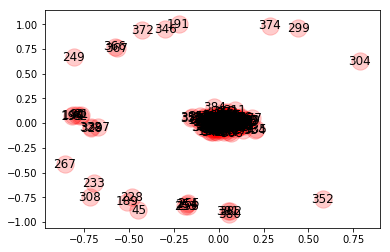

In [901]:
# generate whole graph of genres
G_genre = nx.Graph()
G_genre = nx.from_numpy_matrix(genre_Adj)

G_temp = G_genre
G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
nx.k_core(G_temp)

pos = nx.spring_layout(G_temp)
nx.draw_networkx_nodes(G_temp, pos, alpha=0.2)
#ns = np.array(ec)*3000
#nx.draw_networkx_nodes(G_giant_component, pos, nodelist=centrality.keys(), node_size=ns, alpha=0.75)
nx.draw_networkx_labels(G_temp, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_temp, pos, width=1, alpha=0.4)
plt.show()

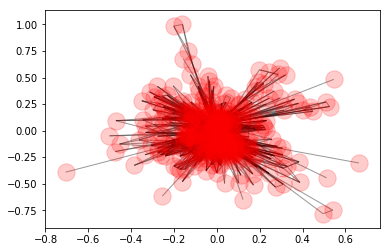

In [902]:
# construct graph with weight
rows, cols = np.where(genre_Adj > 0)
edges = zip(rows.tolist(), cols.tolist())

# find largest component in graph
G_giant_component_genre = max(nx.connected_component_subgraphs(G_genre), key=len)
#G_genre.add_edges_from(edges)

pos = nx.spring_layout(G_giant_component_genre)
nx.draw_networkx_nodes(G_giant_component_genre, pos, alpha=0.2)
#ns = np.array(ec)*3000
#nx.draw_networkx_nodes(G_giant_component, pos, nodelist=centrality.keys(), node_size=ns, alpha=0.75)
#nx.draw_networkx_labels(G_genre, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_genre, pos, width=1, alpha=0.4)
plt.show()

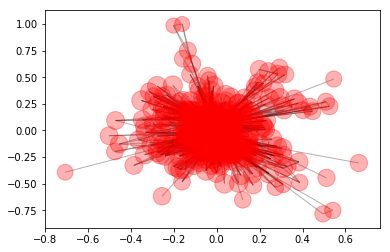

In [903]:
# compute closeness centrality with weight
cc_centrality = nx.closeness_centrality(G_giant_component_genre)
cc = list(cc_centrality.values())

# scale size of nodes
ns = np.array(cc)*1000
nx.draw_networkx_nodes(G_giant_component_genre, pos, nodelist=cc_centrality.keys(), node_size=ns, alpha=0.3)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_genre, pos, alpha=0.3)
plt.show()

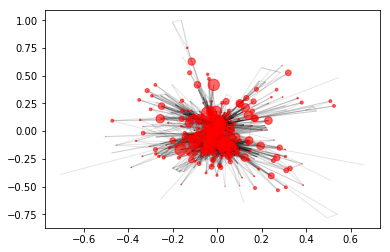

In [904]:
# compute betweenness centrality with weight
bc_centrality = nx.betweenness_centrality(G_giant_component_genre, weight='weight')
bc = list(bc_centrality.values())

# scale size of nodes
ns = np.array(bc)*3000
nx.draw_networkx_nodes(G_giant_component_genre, pos, nodelist=bc_centrality.keys(), node_size=ns, alpha=0.6)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_genre, pos, alpha=0.1)
plt.show()

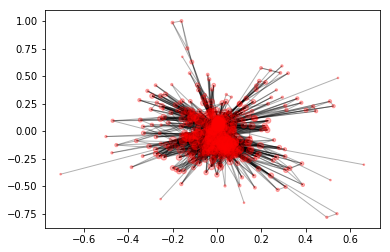

In [905]:
# compute degree centrality with weight
dc_centrality = nx.degree_centrality(G_giant_component_genre)
dc = list(dc_centrality.values())

# scale size of nodes
ns = np.array(dc)*1000
nx.draw_networkx_nodes(G_giant_component_genre, pos, nodelist=dc_centrality.keys(), node_size=ns, alpha=0.3)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_genre, pos, alpha=0.3)
plt.show()

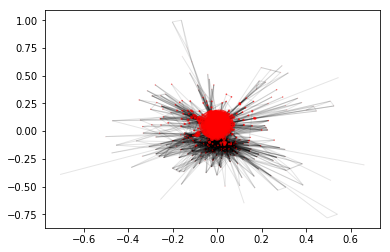

In [906]:
# compute eigenvector centrality with weight
ec_centrality = nx.eigenvector_centrality(G_giant_component_genre, weight='weight')
ec = list(ec_centrality.values())

# scale size of nodes
ns = np.array(ec)*2000
nx.draw_networkx_nodes(G_giant_component_genre, pos, nodelist=ec_centrality.keys(), node_size=ns, alpha=0.6)
#nx.draw_networkx_labels(G_giant_component, pos) # adding labels will result in a mess
nx.draw_networkx_edges(G_giant_component_genre, pos, alpha=0.1)
plt.show()